In [1]:
!nvidia-smi

Sat Mar 22 21:25:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  NVIDIA GeForce RTX 3060        On  | 00000000:02:00.0 Off |                  N/A |
|  0%   39C    P8              10W / 170W |     21MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0   N/A  N/A      1816      G   /usr/lib/xorg/Xorg                            9MiB |
|    0   N

In [2]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model, to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from scipy.ndimage import zoom
from glob import glob
import os
import re
from skimage import measure
import torchio as tio
import shutil
import warnings
warnings.filterwarnings('ignore')

/home/long/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-03-22 21:28:24.185167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 21:28:24.185220: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 21:28:24.185247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 21:28:24.192603: I tensorflow/co

TensorFlow Version: 2.14.0


In [6]:
print("Is GPU Available?", tf.test.is_built_with_cuda())
print("GPU Devices:", tf.config.list_physical_devices("GPU"))

Is GPU Available? True
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

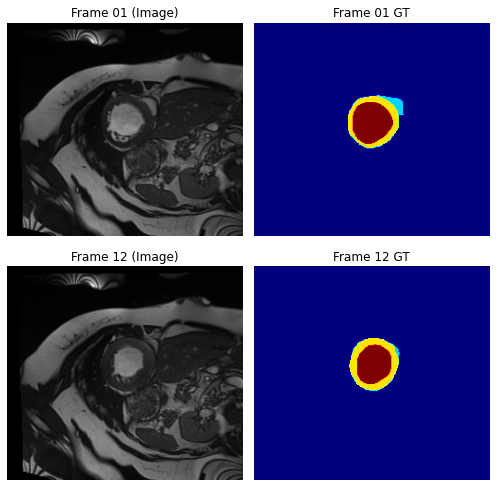

In [4]:
patient_folder = "database/database/training/patient002"
frame_01_path = os.path.join(patient_folder, "patient002_frame01.nii.gz")
frame_01_gt_path = os.path.join(patient_folder, "patient002_frame01_gt.nii.gz")
frame_12_path = os.path.join(patient_folder, "patient002_frame12.nii.gz")
frame_12_gt_path = os.path.join(patient_folder, "patient002_frame12_gt.nii.gz")

frame_01 = load_nifti_image(frame_01_path)
frame_01_gt = load_nifti_image(frame_01_gt_path)
frame_12 = load_nifti_image(frame_12_path)
frame_12_gt = load_nifti_image(frame_12_gt_path)

slice_idx = frame_01.shape[-1] // 2  

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

axes[0, 0].imshow(frame_01[:, :, slice_idx], cmap="gray")
axes[0, 0].set_title("Frame 01 (Image)")

axes[0, 1].imshow(frame_01_gt[:, :, slice_idx], cmap="jet")
axes[0, 1].set_title("Frame 01 GT")

axes[1, 0].imshow(frame_12[:, :, slice_idx], cmap="gray")
axes[1, 0].set_title("Frame 12 (Image)")

axes[1, 1].imshow(frame_12_gt[:, :, slice_idx], cmap="jet")
axes[1, 1].set_title("Frame 12 GT")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
frame_12.shape

(232, 256, 10)

In [5]:
ROOT_DIR = "database/database"
OUTPUT_DIR = "processed"
TRAIN_DIR = os.path.join(ROOT_DIR, "training")
TEST_DIR = os.path.join(ROOT_DIR, "testing")

In [6]:
def resample_nifti_2d(image_path, target_spacing_xy=(1.25, 1.25), is_label=False):
    image = sitk.ReadImage(image_path)
    original_spacing = image.GetSpacing()  # (X, Y, Z)
    original_size = image.GetSize()        

    new_spacing = (target_spacing_xy[0], target_spacing_xy[1], original_spacing[2])

    new_size = [
        int(round(original_size[0] * original_spacing[0] / new_spacing[0])),  # X
        int(round(original_size[1] * original_spacing[1] / new_spacing[1])),  # Y
        original_size[2]  # Z
    ]

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetInterpolator(sitk.sitkNearestNeighbor if is_label else sitk.sitkLinear)

    resampled = resampler.Execute(image)
    print(f"✅ Resampled: XY -> {new_spacing[:2]} | Z unchanged at {original_spacing[2]} | New size: {new_size}")
    return resampled

In [7]:
def normalize_image(image_array):
    mean = image_array.mean()
    std = image_array.std()
    return (image_array - mean) / std if std > 0 else image_array

In [8]:
def resize_2d_slice(image_array, target_shape=(320, 320)):
    zoom_factors = [t / i for t, i in zip(target_shape, image_array.shape)]
    resized_array = zoom(image_array, zoom_factors, order=1)  # Linear interpolation
    return resized_array

In [9]:
def preprocess_image(image_array):
    print(f"Original shape before preprocessing: {image_array.shape}")  

    processed_slices = []
    for i in range(image_array.shape[0]):  
        resized_slice = resize_2d_slice(image_array[i])
        processed_slices.append(resized_slice)

    processed_array = np.stack(processed_slices, axis=0)
    print(f"Final processed shape: {processed_array.shape}")  
    return processed_array

In [10]:
augment_transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1)),  
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10), 
    tio.RandomGamma(log_gamma=(-0.3, 0.3)), 
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=10), 
    tio.RandomMotion(degrees=0, translation=20, num_transforms=1, image_interpolation='linear') 
])

In [11]:
def get_last_frame(patient_folder, patient_id):
    nii_files = os.listdir(patient_folder)
    
    frame_numbers = [
        int(re.search(r'frame(\d+)', f).group(1))
        for f in nii_files if re.search(r'frame(\d+)', f) and "frame01" not in f
    ]
    
    if frame_numbers:
        return max(frame_numbers)  
    else:
        print(f"⚠️ No ES frame found for patient {patient_id}. Skipping ES processing.")
        return None  

In [12]:
def augment_and_save(image, label, output_folder, patient_id, phase):
    tio_image = tio.ScalarImage.from_sitk(image)
    tio_label = tio.LabelMap.from_sitk(label)  
    
    subject = tio.Subject(
        image=tio_image,
        label=tio_label
    )

    augmented_subject = augment_transform(subject)

    augmented_image_path = os.path.join(output_folder, f"patient{patient_id:03d}_{phase}_processed_augmented.nii.gz")
    augmented_subject["image"].save(augmented_image_path)
    print(f"Augmented MRI -> {augmented_image_path}")

    augmented_label_path = os.path.join(output_folder, f"patient{patient_id:03d}_{phase}_gt_processed_augmented.nii.gz")
    augmented_subject["label"].save(augmented_label_path)
    print(f"Augmented GT -> {augmented_label_path}")    

In [13]:
def process_patient(patient_id, dataset_type, apply_augmentation=False):
    patient_folder = os.path.join(ROOT_DIR, dataset_type, f"patient{patient_id:03d}")
    output_folder = os.path.join(OUTPUT_DIR, dataset_type, f"patient{patient_id:03d}")
    os.makedirs(output_folder, exist_ok=True)

    last_frame = get_last_frame(patient_folder, patient_id)
    
    if last_frame is None:
        return  
    
    files = {
        "ED": f"patient{patient_id:03d}_frame01.nii.gz",  
        "ED_gt": f"patient{patient_id:03d}_frame01_gt.nii.gz",
        "ES": f"patient{patient_id:03d}_frame{last_frame:02d}.nii.gz", 
        "ES_gt": f"patient{patient_id:03d}_frame{last_frame:02d}_gt.nii.gz",
    }

    for key, filename in files.items():
        input_path = os.path.join(patient_folder, filename)
        if not os.path.exists(input_path):
            print(f"⚠️ Skipping missing file: {input_path}")
            continue

        is_label = "_gt" in key
        resampled_img = resample_nifti_2d(input_path, is_label=is_label)  
        img_array = sitk.GetArrayFromImage(resampled_img) 

        img_array = preprocess_image(img_array)

        if not is_label:
            img_array = normalize_image(img_array)  

        img_array = np.stack([resize_2d_slice(slice_) for slice_ in img_array], axis=0)

        processed_img = sitk.GetImageFromArray(img_array)

        if processed_img.GetSize() == resampled_img.GetSize():
            processed_img.CopyInformation(resampled_img)
        else:
            print(f"⚠️ Shape mismatch for {filename}. Expected: {resampled_img.GetSize()}, Got: {processed_img.GetSize()}.")

        output_filename = f"patient{patient_id:03d}_{key}_processed.nii.gz"
        output_path = os.path.join(output_folder, output_filename)
        sitk.WriteImage(processed_img, output_path)
        print(f"✅ Processed {filename} -> {output_path}")

        if apply_augmentation and not is_label and dataset_type == "training":
            augment_and_save(processed_img, processed_img, output_folder, patient_id, key)

In [ ]:
train_patients = [f"patient{int(f[7:]):03d}" for f in os.listdir(TRAIN_DIR) if f.startswith("patient")]
test_patients = [f"patient{int(f[7:]):03d}" for f in os.listdir(TEST_DIR) if f.startswith("patient")]

In [ ]:
for patient_id in [int(p[7:]) for p in train_patients]:
    process_patient(patient_id, "training", apply_augmentation=False)

for patient_id in [int(p[7:]) for p in test_patients]:
    process_patient(patient_id, "testing")

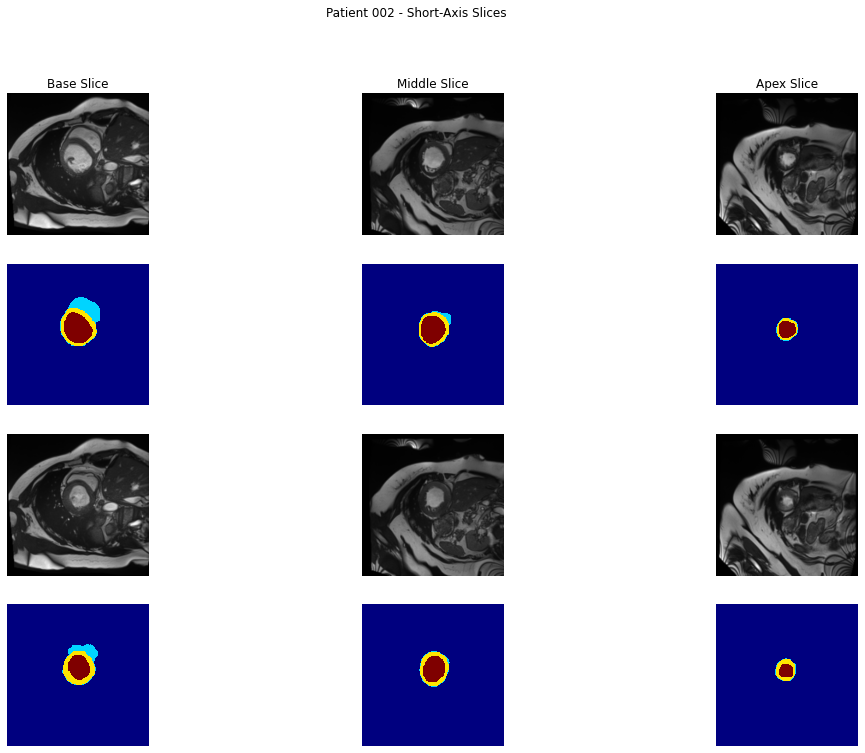

In [16]:
def visualize_patient(patient_id, dataset_type):
    patient_folder = os.path.join(OUTPUT_DIR, dataset_type, f"patient{patient_id:03d}")
    files = {
        "ED": f"patient{patient_id:03d}_ED_processed.nii.gz",
        "ED_gt": f"patient{patient_id:03d}_ED_gt_processed.nii.gz",
        "ES": f"patient{patient_id:03d}_ES_processed.nii.gz",
        "ES_gt": f"patient{patient_id:03d}_ES_gt_processed.nii.gz",
    }
    
    images = {key: nib.load(os.path.join(patient_folder, path)).get_fdata() 
              for key, path in files.items() if os.path.exists(os.path.join(patient_folder, path))}

    slice_positions = {
        "Base": 1,
        "Middle": images["ED"].shape[2] // 2,  
        "Apex": max(images["ED"].shape[2] - 2, 0), 
    }

    fig, axes = plt.subplots(len(images), 3, figsize=(18, 12))

    cmap_seg = plt.get_cmap("jet", 4)  # background, LVC, RVC, LVM
    
    for row_idx, (key, img) in enumerate(images.items()):
        for col_idx, (pos, z) in enumerate(slice_positions.items()):
            ax = axes[row_idx, col_idx]

            slice_img = img[:, :, z]

            if "_gt" in key:
                ax.imshow(slice_img, cmap=cmap_seg, vmin=0, vmax=3)
            else:
                ax.imshow(slice_img, cmap="gray")

            ax.axis("off")
            if row_idx == 0:
                ax.set_title(f"{pos} Slice")

        axes[row_idx, 0].set_ylabel(key, rotation=90, fontsize=12)

    plt.suptitle(f"Patient {patient_id:03d} - Short-Axis Slices")
    plt.show()

visualize_patient(2, "training")

In [17]:
original_img_SA = nib.load(r"database/database/training/patient001/patient001_frame01.nii.gz")
resampled_img_SA = nib.load(r"processed/training/patient001/patient001_ED_processed.nii.gz")

print("ED Preprocessing results:\n---------------------------------------------------------")
print("Original Voxel Spacing:", original_img_SA.header.get_zooms())
print("Resampled Voxel Spacing:", resampled_img_SA.header.get_zooms())
print("Original Shape:", original_img_SA.shape)
print("Resampled Shape:", resampled_img_SA.shape)

original_img_LA = nib.load(r"database/database/training/patient001/patient001_frame12.nii.gz")
resampled_img_LA = nib.load(r"processed/training/patient001/patient001_ES_processed.nii.gz")

print("\n💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯\n\nES Preprocessing results:\n---------------------------------------------------------")
print("Original Voxel Spacing:", original_img_LA.header.get_zooms())
print("Resampled Voxel Spacing:", resampled_img_LA.header.get_zooms())
print("Original Shape:", original_img_LA.shape)
print("Resampled Shape:", resampled_img_LA.shape)

ED Preprocessing results:
---------------------------------------------------------
Original Voxel Spacing: (1.5625, 1.5625, 10.0)
Resampled Voxel Spacing: (1.0, 1.0, 1.0)
Original Shape: (216, 256, 10)
Resampled Shape: (320, 320, 10)

💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯💯

ES Preprocessing results:
---------------------------------------------------------
Original Voxel Spacing: (1.5625, 1.5625, 10.0)
Resampled Voxel Spacing: (1.0, 1.0, 1.0)
Original Shape: (216, 256, 10)
Resampled Shape: (320, 320, 10)


## Training KFold

In [7]:
PROCESSED_DIR = "processed"

for dataset in ["training", "testing"]:
    dataset_path = os.path.join(PROCESSED_DIR, dataset)
    print(f"\n📁 Dataset: {dataset}\n{'-' * 40}")
    
    for patient_folder in os.listdir(dataset_path):
        patient_path = os.path.join(dataset_path, patient_folder)
        
        if not os.path.isdir(patient_path):
            continue

        for file in os.listdir(patient_path):
            if file.endswith(".nii.gz"):
                file_path = os.path.join(patient_path, file)
                
                try:
                    img = nib.load(file_path)
                    voxel_spacing = img.header.get_zooms()
                    shape = img.shape
                    print(f"- {file_path}")
                    print(f"  🧊 Spacing: {voxel_spacing}")
                    print(f"  📐 Shape: {shape}\n")
                except Exception as e:
                    print(f"❌ Error loading {file_path}: {e}")


📁 Dataset: training
----------------------------------------
- processed/training/patient042/patient042_ES_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (320, 320, 9)

- processed/training/patient042/patient042_ED_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (320, 320, 9)

- processed/training/patient042/patient042_ED_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (320, 320, 9)

- processed/training/patient042/patient042_ES_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (320, 320, 9)

- processed/training/patient022/patient022_ED_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (320, 320, 7)

- processed/training/patient022/patient022_ES_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (320, 320, 7)

- processed/training/patient022/patient022_ED_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (320, 320, 7)

- processed/training/patient022/patient022_ES_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shap

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

def unet(input_shape=(320, 320, 1), num_classes=4):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = Conv2D(filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
        x = Conv2D(filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
        return x

    c1 = conv_block(inputs, 48)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 96)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 192)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 384)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 416) 
    
    def upsample_block(x, conv_features, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(x)
        x = concatenate([x, conv_features])
        x = conv_block(x, filters)
        return x

    u6 = upsample_block(c5, c4, 384)
    u7 = upsample_block(u6, c3, 192)
    u8 = upsample_block(u7, c2, 96)
    u9 = upsample_block(u8, c1, 48)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(u9)

    model = Model(inputs, outputs, name="UNet_type_shit")
    return model

model = unet()
model.summary()

Model: "UNet_type_shit"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 320, 320, 48)         480       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 320, 320, 48)         192       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)  (None, 320, 320, 48)         0         ['batch_normaliza

In [12]:
def load_patient_slices(patient_folder, num_classes=4):
    images, masks = [], []

    for phase in ["ED", "ES"]:
        image_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_processed.nii.gz")
        mask_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_gt_processed.nii.gz")

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"⚠️ Missing file: {image_path} or {mask_path}")
            continue  

        image_nii = nib.load(image_path)
        mask_nii = nib.load(mask_path)

        image_array = image_nii.get_fdata()
        mask_array = mask_nii.get_fdata()

        image_array = (image_array - np.mean(image_array)) / (np.std(image_array) + 1e-10)

        for i in range(image_array.shape[2]): 
            img_slice = image_array[:, :, i]
            mask_slice = mask_array[:, :, i]

            img_slice = np.expand_dims(img_slice, axis=-1) 
            
            mask_slice = to_categorical(mask_slice, num_classes=num_classes).astype("float32")

            images.append(img_slice)
            masks.append(mask_slice)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)  

In [ ]:
def load_dataset(root_dir, dataset_type="training"):
    images, masks = [], []
    dataset_path = os.path.join(root_dir, dataset_type)

    for patient_folder in sorted(os.listdir(dataset_path)):
        patient_path = os.path.join(dataset_path, patient_folder)

        if os.path.isdir(patient_path):
            patient_images, patient_masks = load_patient_slices(patient_path)
            # print(f"✅ Loaded {len(patient_images)} images and {len(patient_masks)} masks from {patient_folder}")
            images.extend(patient_images)
            masks.extend(patient_masks)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

X_train, Y_train = load_dataset("processed", "training")
X_val, Y_val = load_dataset('processed', 'validation')
X_test, Y_test = load_dataset("processed", "testing")

print(f"✅ Training Data: {X_train.shape}, {Y_train.shape}")
print(f"✅ Testing Data: {X_test.shape}, {Y_test.shape}")

✅ Training Data: (1902, 320, 320, 1), (1902, 320, 320, 4)
✅ Testing Data: (1076, 320, 320, 1), (1076, 320, 320, 4)


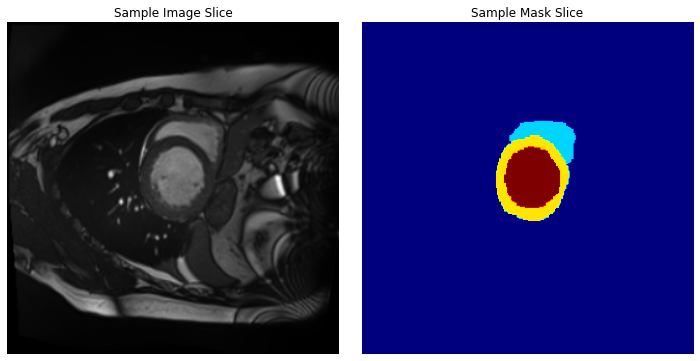

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(X_train[13, :, :, 0], cmap="gray")
ax[0].set_title("Sample Image Slice")
ax[0].axis("off")

ax[1].imshow(np.argmax(Y_train[13], axis=-1), cmap="jet")
ax[1].set_title("Sample Mask Slice")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [8]:
def create_tf_dataset(images, masks, batch_size=4):
    images = images.astype("float32") 
    masks = masks.astype("float32")  

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


K_FOLDS = 5
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

    train_dataset = create_tf_dataset(X_train_fold, Y_train_fold, batch_size=4)
    valid_dataset = create_tf_dataset(X_val_fold, Y_val_fold, batch_size=4)

In [12]:
def dice_loss_per_class(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []
    
    for i in range(num_classes):
        y_true_class = K.flatten(y_true[..., i])
        y_pred_class = K.flatten(y_pred[..., i])

        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)

    return 1 - K.mean(K.stack(dice_scores), axis=0)  

def dice_score_per_class(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []
    
    for i in range(num_classes):
        y_true_class = K.flatten(y_true[..., i])
        y_pred_class = K.flatten(y_pred[..., i])

        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)

    return K.mean(K.stack(dice_scores), axis=0)  

def dice_metric(y_true, y_pred):
    return dice_score_per_class(y_true, y_pred, num_classes=4)

def dice_score_each_individual_class(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []

    for i in range(num_classes):
        y_true_class = tf.keras.backend.flatten(y_true[..., i])
        y_pred_class = tf.keras.backend.flatten(y_pred[..., i])

        intersection = tf.keras.backend.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (
            tf.keras.backend.sum(y_true_class) + tf.keras.backend.sum(y_pred_class) + smooth
        )
        dice_scores.append(dice)

    return dice_scores  

In [13]:
decay_steps = 18000
initial_learning_rate = 0.001
lr_schedule = CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=initial_learning_rate * 0.1
)

In [14]:
K_FOLDS = 5
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

EPOCHS = 45
BATCH_SIZE = 4

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n🚀 Training Fold {fold + 1}/{K_FOLDS}...\n")

    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

    train_dataset = create_tf_dataset(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE)
    valid_dataset = create_tf_dataset(X_val_fold, Y_val_fold, batch_size=BATCH_SIZE)

    model = unet(input_shape=(320, 320, 1), num_classes=4)

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(
        optimizer=optimizer,
        loss=dice_loss_per_class,
        metrics=[dice_metric]
    )

    checkpoint = ModelCheckpoint(
        filepath=f'models/session_1/best_unet2d_acdc_fold{fold+1}', 
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=2
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=10,
        min_lr=0.0001,
        verbose=1
    )

    model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint, reduce_lr]
    )

    print(f"✅ Finished training fold {fold+1}/{K_FOLDS}\n")


🚀 Training Fold 1/5...



2025-03-21 23:50:17.030117: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/45


2025-03-21 23:50:23.349301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-03-21 23:50:23.459182: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-21 23:50:24.846132: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-21 23:50:25.483571: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe4f07fb4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-21 23:50:25.483594: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-21 23:50:25.488253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:

381/381 [==============================] - ETA: 0s - loss: 0.3673 - dice_metric: 0.6332
Epoch 1: val_loss improved from inf to 0.39013, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 77s 159ms/step - loss: 0.3673 - dice_metric: 0.6332 - val_loss: 0.3901 - val_dice_metric: 0.6098 - lr: 9.9890e-04
Epoch 2/45
380/381 [============================>.] - ETA: 0s - loss: 0.1568 - dice_metric: 0.8432
Epoch 2: val_loss improved from 0.39013 to 0.15278, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.1568 - dice_metric: 0.8430 - val_loss: 0.1528 - val_dice_metric: 0.8474 - lr: 9.9560e-04
Epoch 3/45
380/381 [============================>.] - ETA: 0s - loss: 0.1325 - dice_metric: 0.8675
Epoch 3: val_loss improved from 0.15278 to 0.12855, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1329 - dice_metric: 0.8659 - val_loss: 0.1286 - val_dice_metric: 0.8666 - lr: 9.9010e-04
Epoch 4/45
380/381 [============================>.] - ETA: 0s - loss: 0.1261 - dice_metric: 0.8739
Epoch 4: val_loss did not improve from 0.12855
381/381 [==============================] - 50s 131ms/step - loss: 0.1261 - dice_metric: 0.8740 - val_loss: 0.1354 - val_dice_metric: 0.8598 - lr: 9.8244e-04
Epoch 5/45
380/381 [============================>.] - ETA: 0s - loss: 0.1130 - dice_metric: 0.8870
Epoch 5: val_loss improved from 0.12855 to 0.12054, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.1130 - dice_metric: 0.8870 - val_loss: 0.1205 - val_dice_metric: 0.8797 - lr: 9.7265e-04
Epoch 6/45
380/381 [============================>.] - ETA: 0s - loss: 0.1004 - dice_metric: 0.8996
Epoch 6: val_loss did not improve from 0.12054
381/381 [==============================] - 50s 130ms/step - loss: 0.1004 - dice_metric: 0.8997 - val_loss: 0.1274 - val_dice_metric: 0.8677 - lr: 9.6077e-04
Epoch 7/45
380/381 [============================>.] - ETA: 0s - loss: 0.0977 - dice_metric: 0.9023
Epoch 7: val_loss improved from 0.12054 to 0.11966, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.0977 - dice_metric: 0.9023 - val_loss: 0.1197 - val_dice_metric: 0.8781 - lr: 9.4685e-04
Epoch 8/45
380/381 [============================>.] - ETA: 0s - loss: 0.0968 - dice_metric: 0.9032
Epoch 8: val_loss improved from 0.11966 to 0.11725, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0969 - dice_metric: 0.9027 - val_loss: 0.1172 - val_dice_metric: 0.8810 - lr: 9.3095e-04
Epoch 9/45
380/381 [============================>.] - ETA: 0s - loss: 0.0923 - dice_metric: 0.9077
Epoch 9: val_loss did not improve from 0.11725
381/381 [==============================] - 50s 131ms/step - loss: 0.0923 - dice_metric: 0.9077 - val_loss: 0.1173 - val_dice_metric: 0.8824 - lr: 9.1316e-04
Epoch 10/45
380/381 [============================>.] - ETA: 0s - loss: 0.0917 - dice_metric: 0.9083
Epoch 10: val_loss improved from 0.11725 to 0.09673, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0917 - dice_metric: 0.9083 - val_loss: 0.0967 - val_dice_metric: 0.9037 - lr: 8.9353e-04
Epoch 11/45
380/381 [============================>.] - ETA: 0s - loss: 0.0890 - dice_metric: 0.9110
Epoch 11: val_loss improved from 0.09673 to 0.09595, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.0890 - dice_metric: 0.9111 - val_loss: 0.0960 - val_dice_metric: 0.9036 - lr: 8.7217e-04
Epoch 12/45
380/381 [============================>.] - ETA: 0s - loss: 0.0811 - dice_metric: 0.9189
Epoch 12: val_loss did not improve from 0.09595
381/381 [==============================] - 50s 131ms/step - loss: 0.0811 - dice_metric: 0.9188 - val_loss: 0.1151 - val_dice_metric: 0.8850 - lr: 8.4916e-04
Epoch 13/45
380/381 [============================>.] - ETA: 0s - loss: 0.0838 - dice_metric: 0.9162
Epoch 13: val_loss improved from 0.09595 to 0.09243, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0841 - dice_metric: 0.9150 - val_loss: 0.0924 - val_dice_metric: 0.9079 - lr: 8.2461e-04
Epoch 14/45
380/381 [============================>.] - ETA: 0s - loss: 0.0793 - dice_metric: 0.9207
Epoch 14: val_loss improved from 0.09243 to 0.09172, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0793 - dice_metric: 0.9206 - val_loss: 0.0917 - val_dice_metric: 0.9080 - lr: 7.9862e-04
Epoch 15/45
380/381 [============================>.] - ETA: 0s - loss: 0.0760 - dice_metric: 0.9240
Epoch 15: val_loss did not improve from 0.09172
381/381 [==============================] - 50s 131ms/step - loss: 0.0760 - dice_metric: 0.9240 - val_loss: 0.0963 - val_dice_metric: 0.9039 - lr: 7.7132e-04
Epoch 16/45
380/381 [============================>.] - ETA: 0s - loss: 0.0759 - dice_metric: 0.9241
Epoch 16: val_loss improved from 0.09172 to 0.08517, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0759 - dice_metric: 0.9241 - val_loss: 0.0852 - val_dice_metric: 0.9133 - lr: 7.4281e-04
Epoch 17/45
380/381 [============================>.] - ETA: 0s - loss: 0.0740 - dice_metric: 0.9260
Epoch 17: val_loss did not improve from 0.08517
381/381 [==============================] - 50s 131ms/step - loss: 0.0740 - dice_metric: 0.9259 - val_loss: 0.0867 - val_dice_metric: 0.9128 - lr: 7.1323e-04
Epoch 18/45
380/381 [============================>.] - ETA: 0s - loss: 0.0682 - dice_metric: 0.9318
Epoch 18: val_loss improved from 0.08517 to 0.07806, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 144ms/step - loss: 0.0683 - dice_metric: 0.9314 - val_loss: 0.0781 - val_dice_metric: 0.9221 - lr: 6.8271e-04
Epoch 19/45
380/381 [============================>.] - ETA: 0s - loss: 0.0697 - dice_metric: 0.9303
Epoch 19: val_loss did not improve from 0.07806
381/381 [==============================] - 50s 131ms/step - loss: 0.0697 - dice_metric: 0.9304 - val_loss: 0.0887 - val_dice_metric: 0.9101 - lr: 6.5139e-04
Epoch 20/45
380/381 [============================>.] - ETA: 0s - loss: 0.0755 - dice_metric: 0.9245
Epoch 20: val_loss did not improve from 0.07806
381/381 [==============================] - 50s 131ms/step - loss: 0.0760 - dice_metric: 0.9227 - val_loss: 0.0857 - val_dice_metric: 0.9131 - lr: 6.1939e-04
Epoch 21/45
380/381 [============================>.] - ETA: 0s - loss: 0.0683 - dice_metric: 0.9317
Epoch 21: val_loss did not improve from 0.07806
381/381 [==============================] - 50s 131ms/step - loss: 0.0683 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0686 - dice_metric: 0.9314 - val_loss: 0.0772 - val_dice_metric: 0.9229 - lr: 5.2081e-04
Epoch 24/45
380/381 [============================>.] - ETA: 0s - loss: 0.0638 - dice_metric: 0.9362
Epoch 24: val_loss improved from 0.07715 to 0.07442, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.0638 - dice_metric: 0.9363 - val_loss: 0.0744 - val_dice_metric: 0.9238 - lr: 4.8757e-04
Epoch 25/45
380/381 [============================>.] - ETA: 0s - loss: 0.0631 - dice_metric: 0.9369
Epoch 25: val_loss did not improve from 0.07442
381/381 [==============================] - 50s 131ms/step - loss: 0.0631 - dice_metric: 0.9369 - val_loss: 0.0771 - val_dice_metric: 0.9231 - lr: 4.5439e-04
Epoch 26/45
380/381 [============================>.] - ETA: 0s - loss: 0.0633 - dice_metric: 0.9367
Epoch 26: val_loss improved from 0.07442 to 0.07248, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0634 - dice_metric: 0.9366 - val_loss: 0.0725 - val_dice_metric: 0.9222 - lr: 4.2141e-04
Epoch 27/45
380/381 [============================>.] - ETA: 0s - loss: 0.0607 - dice_metric: 0.9393
Epoch 27: val_loss improved from 0.07248 to 0.07087, saving model to models/session_1/best_unet2d_acdc_fold1
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0607 - dice_metric: 0.9392 - val_loss: 0.0709 - val_dice_metric: 0.9292 - lr: 3.8878e-04
Epoch 28/45
380/381 [============================>.] - ETA: 0s - loss: 0.0613 - dice_metric: 0.9387
Epoch 28: val_loss did not improve from 0.07087
381/381 [==============================] - 50s 130ms/step - loss: 0.0613 - dice_metric: 0.9387 - val_loss: 0.0828 - val_dice_metric: 0.9176 - lr: 3.5663e-04
Epoch 29/45
380/381 [============================>.] - ETA: 0s - loss: 0.0608 - dice_metric: 0.9392
Epoch 29: val_loss did not improve from 0.07087
381/381 [==============================] - 50s 131ms/step - loss: 0.0608 - dice_metric: 0.9393 - val_loss: 0.0755 - val_dice_metric: 0.9192 - lr: 3.2513e-04
Epoch 30/45
380/381 [============================>.] - ETA: 0s - loss: 0.0585 - dice_metric: 0.9415
Epoch 30: val_loss did not improve from 0.07087
381/381 [==============================] - 50s 131ms/step - loss: 0.0585 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.0579 - dice_metric: 0.9419 - val_loss: 0.0692 - val_dice_metric: 0.9288 - lr: 2.0817e-04
Epoch 34/45
380/381 [============================>.] - ETA: 0s - loss: 0.0563 - dice_metric: 0.9437
Epoch 34: val_loss did not improve from 0.06922
381/381 [==============================] - 50s 130ms/step - loss: 0.0563 - dice_metric: 0.9437 - val_loss: 0.0704 - val_dice_metric: 0.9298 - lr: 1.8184e-04
Epoch 35/45
380/381 [============================>.] - ETA: 0s - loss: 0.0563 - dice_metric: 0.9437
Epoch 35: val_loss did not improve from 0.06922
381/381 [==============================] - 50s 131ms/step - loss: 0.0563 - dice_metric: 0.9437 - val_loss: 0.0730 - val_dice_metric: 0.9265 - lr: 1.5692e-04
Epoch 36/45
380/381 [============================>.] - ETA: 0s - loss: 0.0542 - dice_metric: 0.9458
Epoch 36: val_loss did not improve from 0.06922
381/381 [==============================] - 50s 131ms/step - loss: 0.0542 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold1/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0521 - dice_metric: 0.9479 - val_loss: 0.0690 - val_dice_metric: 0.9310 - lr: 5.6691e-06
✅ Finished training fold 1/5


🚀 Training Fold 2/5...

Epoch 1/45
380/381 [============================>.] - ETA: 0s - loss: 0.4085 - dice_metric: 0.5915
Epoch 1: val_loss improved from inf to 0.47821, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 66s 149ms/step - loss: 0.4083 - dice_metric: 0.5923 - val_loss: 0.4782 - val_dice_metric: 0.5241 - lr: 9.9890e-04
Epoch 2/45
380/381 [============================>.] - ETA: 0s - loss: 0.1643 - dice_metric: 0.8357
Epoch 2: val_loss improved from 0.47821 to 0.17053, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1643 - dice_metric: 0.8359 - val_loss: 0.1705 - val_dice_metric: 0.8301 - lr: 9.9560e-04
Epoch 3/45
380/381 [============================>.] - ETA: 0s - loss: 0.1307 - dice_metric: 0.8693
Epoch 3: val_loss improved from 0.17053 to 0.11099, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.1309 - dice_metric: 0.8685 - val_loss: 0.1110 - val_dice_metric: 0.8892 - lr: 9.9010e-04
Epoch 4/45
380/381 [============================>.] - ETA: 0s - loss: 0.1215 - dice_metric: 0.8785
Epoch 4: val_loss did not improve from 0.11099
381/381 [==============================] - 50s 132ms/step - loss: 0.1219 - dice_metric: 0.8771 - val_loss: 0.1457 - val_dice_metric: 0.8545 - lr: 9.8244e-04
Epoch 5/45
380/381 [============================>.] - ETA: 0s - loss: 0.1094 - dice_metric: 0.8906
Epoch 5: val_loss improved from 0.11099 to 0.10954, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1093 - dice_metric: 0.8907 - val_loss: 0.1095 - val_dice_metric: 0.8890 - lr: 9.7265e-04
Epoch 6/45
380/381 [============================>.] - ETA: 0s - loss: 0.1024 - dice_metric: 0.8976
Epoch 6: val_loss did not improve from 0.10954
381/381 [==============================] - 50s 131ms/step - loss: 0.1024 - dice_metric: 0.8977 - val_loss: 0.1244 - val_dice_metric: 0.8722 - lr: 9.6077e-04
Epoch 7/45
380/381 [============================>.] - ETA: 0s - loss: 0.1034 - dice_metric: 0.8966
Epoch 7: val_loss did not improve from 0.10954
381/381 [==============================] - 50s 132ms/step - loss: 0.1035 - dice_metric: 0.8962 - val_loss: 0.1643 - val_dice_metric: 0.8365 - lr: 9.4685e-04
Epoch 8/45
380/381 [============================>.] - ETA: 0s - loss: 0.0935 - dice_metric: 0.9065
Epoch 8: val_loss improved from 0.10954 to 0.09725, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0937 - dice_metric: 0.9059 - val_loss: 0.0973 - val_dice_metric: 0.9011 - lr: 9.3095e-04
Epoch 9/45
380/381 [============================>.] - ETA: 0s - loss: 0.0917 - dice_metric: 0.9083
Epoch 9: val_loss did not improve from 0.09725
381/381 [==============================] - 50s 131ms/step - loss: 0.0916 - dice_metric: 0.9085 - val_loss: 0.1023 - val_dice_metric: 0.8975 - lr: 9.1316e-04
Epoch 10/45
380/381 [============================>.] - ETA: 0s - loss: 0.0879 - dice_metric: 0.9121
Epoch 10: val_loss improved from 0.09725 to 0.08942, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 148ms/step - loss: 0.0879 - dice_metric: 0.9121 - val_loss: 0.0894 - val_dice_metric: 0.9107 - lr: 8.9353e-04
Epoch 11/45
380/381 [============================>.] - ETA: 0s - loss: 0.0797 - dice_metric: 0.9203
Epoch 11: val_loss did not improve from 0.08942
381/381 [==============================] - 50s 131ms/step - loss: 0.0797 - dice_metric: 0.9202 - val_loss: 0.0977 - val_dice_metric: 0.9024 - lr: 8.7217e-04
Epoch 12/45
380/381 [============================>.] - ETA: 0s - loss: 0.0803 - dice_metric: 0.9197
Epoch 12: val_loss did not improve from 0.08942
381/381 [==============================] - 50s 131ms/step - loss: 0.0803 - dice_metric: 0.9198 - val_loss: 0.1006 - val_dice_metric: 0.8971 - lr: 8.4916e-04
Epoch 13/45
380/381 [============================>.] - ETA: 0s - loss: 0.0821 - dice_metric: 0.9179
Epoch 13: val_loss did not improve from 0.08942
381/381 [==============================] - 50s 131ms/step - loss: 0.0821 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0765 - dice_metric: 0.9234 - val_loss: 0.0870 - val_dice_metric: 0.9079 - lr: 7.7132e-04
Epoch 16/45
380/381 [============================>.] - ETA: 0s - loss: 0.0801 - dice_metric: 0.9199
Epoch 16: val_loss did not improve from 0.08703
381/381 [==============================] - 50s 131ms/step - loss: 0.0800 - dice_metric: 0.9200 - val_loss: 0.1027 - val_dice_metric: 0.8976 - lr: 7.4281e-04
Epoch 17/45
380/381 [============================>.] - ETA: 0s - loss: 0.0737 - dice_metric: 0.9263
Epoch 17: val_loss improved from 0.08703 to 0.08358, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.0737 - dice_metric: 0.9263 - val_loss: 0.0836 - val_dice_metric: 0.9167 - lr: 7.1323e-04
Epoch 18/45
380/381 [============================>.] - ETA: 0s - loss: 0.0700 - dice_metric: 0.9300
Epoch 18: val_loss did not improve from 0.08358
381/381 [==============================] - 50s 132ms/step - loss: 0.0700 - dice_metric: 0.9300 - val_loss: 0.0929 - val_dice_metric: 0.9072 - lr: 6.8271e-04
Epoch 19/45
380/381 [============================>.] - ETA: 0s - loss: 0.0719 - dice_metric: 0.9281
Epoch 19: val_loss did not improve from 0.08358
381/381 [==============================] - 50s 131ms/step - loss: 0.0719 - dice_metric: 0.9281 - val_loss: 0.0888 - val_dice_metric: 0.9115 - lr: 6.5139e-04
Epoch 20/45
380/381 [============================>.] - ETA: 0s - loss: 0.0721 - dice_metric: 0.9279
Epoch 20: val_loss improved from 0.08358 to 0.08324, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0721 - dice_metric: 0.9280 - val_loss: 0.0832 - val_dice_metric: 0.9167 - lr: 6.1939e-04
Epoch 21/45
380/381 [============================>.] - ETA: 0s - loss: 0.0687 - dice_metric: 0.9313
Epoch 21: val_loss improved from 0.08324 to 0.07997, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.0686 - dice_metric: 0.9314 - val_loss: 0.0800 - val_dice_metric: 0.9185 - lr: 5.8687e-04
Epoch 22/45
380/381 [============================>.] - ETA: 0s - loss: 0.0654 - dice_metric: 0.9346
Epoch 22: val_loss improved from 0.07997 to 0.07574, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0654 - dice_metric: 0.9347 - val_loss: 0.0757 - val_dice_metric: 0.9225 - lr: 5.5396e-04
Epoch 23/45
380/381 [============================>.] - ETA: 0s - loss: 0.0631 - dice_metric: 0.9369
Epoch 23: val_loss did not improve from 0.07574
381/381 [==============================] - 50s 131ms/step - loss: 0.0631 - dice_metric: 0.9370 - val_loss: 0.0873 - val_dice_metric: 0.9090 - lr: 5.2081e-04
Epoch 24/45
380/381 [============================>.] - ETA: 0s - loss: 0.0650 - dice_metric: 0.9350
Epoch 24: val_loss did not improve from 0.07574
381/381 [==============================] - 50s 132ms/step - loss: 0.0652 - dice_metric: 0.9344 - val_loss: 0.0956 - val_dice_metric: 0.9016 - lr: 4.8757e-04
Epoch 25/45
380/381 [============================>.] - ETA: 0s - loss: 0.0704 - dice_metric: 0.9296
Epoch 25: val_loss improved from 0.07574 to 0.07526, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0703 - dice_metric: 0.9297 - val_loss: 0.0753 - val_dice_metric: 0.9248 - lr: 4.5439e-04
Epoch 26/45
380/381 [============================>.] - ETA: 0s - loss: 0.0620 - dice_metric: 0.9380
Epoch 26: val_loss did not improve from 0.07526
381/381 [==============================] - 50s 131ms/step - loss: 0.0622 - dice_metric: 0.9374 - val_loss: 0.0756 - val_dice_metric: 0.9245 - lr: 4.2141e-04
Epoch 27/45
380/381 [============================>.] - ETA: 0s - loss: 0.0627 - dice_metric: 0.9373
Epoch 27: val_loss did not improve from 0.07526
381/381 [==============================] - 50s 132ms/step - loss: 0.0627 - dice_metric: 0.9373 - val_loss: 0.0780 - val_dice_metric: 0.9222 - lr: 3.8878e-04
Epoch 28/45
380/381 [============================>.] - ETA: 0s - loss: 0.0602 - dice_metric: 0.9398
Epoch 28: val_loss improved from 0.07526 to 0.07111, saving model to models/session_1/best_unet2d_acdc_fold2
INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.0601 - dice_metric: 0.9399 - val_loss: 0.0711 - val_dice_metric: 0.9288 - lr: 3.5663e-04
Epoch 29/45
380/381 [============================>.] - ETA: 0s - loss: 0.0593 - dice_metric: 0.9407
Epoch 29: val_loss did not improve from 0.07111
381/381 [==============================] - 50s 131ms/step - loss: 0.0595 - dice_metric: 0.9401 - val_loss: 0.0832 - val_dice_metric: 0.9168 - lr: 3.2513e-04
Epoch 30/45
380/381 [============================>.] - ETA: 0s - loss: 0.0606 - dice_metric: 0.9394
Epoch 30: val_loss did not improve from 0.07111
381/381 [==============================] - 50s 131ms/step - loss: 0.0606 - dice_metric: 0.9394 - val_loss: 0.0713 - val_dice_metric: 0.9289 - lr: 2.9439e-04
Epoch 31/45
380/381 [============================>.] - ETA: 0s - loss: 0.0575 - dice_metric: 0.9425
Epoch 31: val_loss did not improve from 0.07111
381/381 [==============================] - 50s 131ms/step - loss: 0.0575 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0577 - dice_metric: 0.9423 - val_loss: 0.0704 - val_dice_metric: 0.9243 - lr: 2.0817e-04
Epoch 34/45
380/381 [============================>.] - ETA: 0s - loss: 0.0547 - dice_metric: 0.9453
Epoch 34: val_loss did not improve from 0.07039
381/381 [==============================] - 50s 131ms/step - loss: 0.0552 - dice_metric: 0.9434 - val_loss: 0.0726 - val_dice_metric: 0.9257 - lr: 1.8184e-04
Epoch 35/45
380/381 [============================>.] - ETA: 0s - loss: 0.0548 - dice_metric: 0.9452
Epoch 35: val_loss did not improve from 0.07039
381/381 [==============================] - 50s 131ms/step - loss: 0.0548 - dice_metric: 0.9452 - val_loss: 0.0747 - val_dice_metric: 0.9200 - lr: 1.5692e-04
Epoch 36/45
380/381 [============================>.] - ETA: 0s - loss: 0.0553 - dice_metric: 0.9447
Epoch 36: val_loss did not improve from 0.07039
381/381 [==============================] - 50s 132ms/step - loss: 0.0553 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold2/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0555 - dice_metric: 0.9440 - val_loss: 0.0688 - val_dice_metric: 0.9313 - lr: 9.1669e-05
Epoch 39/45
380/381 [============================>.] - ETA: 0s - loss: 0.0540 - dice_metric: 0.9460
Epoch 39: val_loss did not improve from 0.06877
381/381 [==============================] - 50s 131ms/step - loss: 0.0540 - dice_metric: 0.9460 - val_loss: 0.0726 - val_dice_metric: 0.9275 - lr: 7.3408e-05
Epoch 40/45
380/381 [============================>.] - ETA: 0s - loss: 0.0544 - dice_metric: 0.9456
Epoch 40: val_loss did not improve from 0.06877
381/381 [==============================] - 50s 131ms/step - loss: 0.0544 - dice_metric: 0.9456 - val_loss: 0.0711 - val_dice_metric: 0.9271 - lr: 5.7033e-05
Epoch 41/45
380/381 [============================>.] - ETA: 0s - loss: 0.0528 - dice_metric: 0.9472
Epoch 41: val_loss did not improve from 0.06877
381/381 [==============================] - 50s 132ms/step - loss: 0.0528 - dice_metri

2025-03-22 01:10:06.654627: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-22 01:10:09.355981: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


381/381 [==============================] - ETA: 0s - loss: 0.3986 - dice_metric: 0.6016
Epoch 1: val_loss improved from inf to 0.38905, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 71s 162ms/step - loss: 0.3986 - dice_metric: 0.6016 - val_loss: 0.3891 - val_dice_metric: 0.6109 - lr: 9.9890e-04
Epoch 2/45
381/381 [==============================] - ETA: 0s - loss: 0.1675 - dice_metric: 0.8325
Epoch 2: val_loss improved from 0.38905 to 0.19434, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1675 - dice_metric: 0.8325 - val_loss: 0.1943 - val_dice_metric: 0.8057 - lr: 9.9560e-04
Epoch 3/45
381/381 [==============================] - ETA: 0s - loss: 0.1391 - dice_metric: 0.8610
Epoch 3: val_loss improved from 0.19434 to 0.12539, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1391 - dice_metric: 0.8610 - val_loss: 0.1254 - val_dice_metric: 0.8746 - lr: 9.9010e-04
Epoch 4/45
381/381 [==============================] - ETA: 0s - loss: 0.1225 - dice_metric: 0.8775
Epoch 4: val_loss improved from 0.12539 to 0.10966, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.1225 - dice_metric: 0.8775 - val_loss: 0.1097 - val_dice_metric: 0.8903 - lr: 9.8244e-04
Epoch 5/45
381/381 [==============================] - ETA: 0s - loss: 0.1168 - dice_metric: 0.8832
Epoch 5: val_loss did not improve from 0.10966
381/381 [==============================] - 50s 130ms/step - loss: 0.1168 - dice_metric: 0.8832 - val_loss: 0.1532 - val_dice_metric: 0.8468 - lr: 9.7265e-04
Epoch 6/45
381/381 [==============================] - ETA: 0s - loss: 0.1050 - dice_metric: 0.8950
Epoch 6: val_loss improved from 0.10966 to 0.09680, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.1050 - dice_metric: 0.8950 - val_loss: 0.0968 - val_dice_metric: 0.9032 - lr: 9.6077e-04
Epoch 7/45
381/381 [==============================] - ETA: 0s - loss: 0.1059 - dice_metric: 0.8941
Epoch 7: val_loss improved from 0.09680 to 0.09517, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1059 - dice_metric: 0.8941 - val_loss: 0.0952 - val_dice_metric: 0.9048 - lr: 9.4685e-04
Epoch 8/45
381/381 [==============================] - ETA: 0s - loss: 0.1017 - dice_metric: 0.8984
Epoch 8: val_loss did not improve from 0.09517
381/381 [==============================] - 50s 131ms/step - loss: 0.1017 - dice_metric: 0.8984 - val_loss: 0.0978 - val_dice_metric: 0.9022 - lr: 9.3095e-04
Epoch 9/45
381/381 [==============================] - ETA: 0s - loss: 0.0961 - dice_metric: 0.9037
Epoch 9: val_loss improved from 0.09517 to 0.09247, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0961 - dice_metric: 0.9037 - val_loss: 0.0925 - val_dice_metric: 0.9075 - lr: 9.1316e-04
Epoch 10/45
381/381 [==============================] - ETA: 0s - loss: 0.0980 - dice_metric: 0.9019
Epoch 10: val_loss did not improve from 0.09247
381/381 [==============================] - 50s 131ms/step - loss: 0.0980 - dice_metric: 0.9019 - val_loss: 0.1183 - val_dice_metric: 0.8817 - lr: 8.9353e-04
Epoch 11/45
381/381 [==============================] - ETA: 0s - loss: 0.0936 - dice_metric: 0.9064
Epoch 11: val_loss did not improve from 0.09247
381/381 [==============================] - 50s 131ms/step - loss: 0.0936 - dice_metric: 0.9064 - val_loss: 0.1106 - val_dice_metric: 0.8894 - lr: 8.7217e-04
Epoch 12/45
381/381 [==============================] - ETA: 0s - loss: 0.0895 - dice_metric: 0.9105
Epoch 12: val_loss improved from 0.09247 to 0.08772, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0895 - dice_metric: 0.9105 - val_loss: 0.0877 - val_dice_metric: 0.9123 - lr: 8.4916e-04
Epoch 13/45
381/381 [==============================] - ETA: 0s - loss: 0.0819 - dice_metric: 0.9181
Epoch 13: val_loss improved from 0.08772 to 0.08126, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0819 - dice_metric: 0.9181 - val_loss: 0.0813 - val_dice_metric: 0.9187 - lr: 8.2461e-04
Epoch 14/45
381/381 [==============================] - ETA: 0s - loss: 0.0799 - dice_metric: 0.9201
Epoch 14: val_loss did not improve from 0.08126
381/381 [==============================] - 50s 130ms/step - loss: 0.0799 - dice_metric: 0.9201 - val_loss: 0.0835 - val_dice_metric: 0.9165 - lr: 7.9862e-04
Epoch 15/45
381/381 [==============================] - ETA: 0s - loss: 0.0781 - dice_metric: 0.9219
Epoch 15: val_loss did not improve from 0.08126
381/381 [==============================] - 50s 131ms/step - loss: 0.0781 - dice_metric: 0.9219 - val_loss: 0.0882 - val_dice_metric: 0.9118 - lr: 7.7132e-04
Epoch 16/45
381/381 [==============================] - ETA: 0s - loss: 0.0770 - dice_metric: 0.9231
Epoch 16: val_loss did not improve from 0.08126
381/381 [==============================] - 50s 131ms/step - loss: 0.0770 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0756 - dice_metric: 0.9244 - val_loss: 0.0727 - val_dice_metric: 0.9273 - lr: 6.5139e-04
Epoch 20/45
381/381 [==============================] - ETA: 0s - loss: 0.0708 - dice_metric: 0.9293
Epoch 20: val_loss did not improve from 0.07274
381/381 [==============================] - 50s 131ms/step - loss: 0.0708 - dice_metric: 0.9293 - val_loss: 0.0762 - val_dice_metric: 0.9238 - lr: 6.1939e-04
Epoch 21/45
381/381 [==============================] - ETA: 0s - loss: 0.0702 - dice_metric: 0.9298
Epoch 21: val_loss improved from 0.07274 to 0.07102, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0702 - dice_metric: 0.9298 - val_loss: 0.0710 - val_dice_metric: 0.9290 - lr: 5.8687e-04
Epoch 22/45
381/381 [==============================] - ETA: 0s - loss: 0.0670 - dice_metric: 0.9330
Epoch 22: val_loss improved from 0.07102 to 0.06995, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0670 - dice_metric: 0.9330 - val_loss: 0.0700 - val_dice_metric: 0.9300 - lr: 5.5396e-04
Epoch 23/45
381/381 [==============================] - ETA: 0s - loss: 0.0652 - dice_metric: 0.9348
Epoch 23: val_loss improved from 0.06995 to 0.06881, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.0652 - dice_metric: 0.9348 - val_loss: 0.0688 - val_dice_metric: 0.9312 - lr: 5.2081e-04
Epoch 24/45
381/381 [==============================] - ETA: 0s - loss: 0.0644 - dice_metric: 0.9355
Epoch 24: val_loss did not improve from 0.06881
381/381 [==============================] - 50s 131ms/step - loss: 0.0644 - dice_metric: 0.9355 - val_loss: 0.0710 - val_dice_metric: 0.9290 - lr: 4.8757e-04
Epoch 25/45
381/381 [==============================] - ETA: 0s - loss: 0.0652 - dice_metric: 0.9347
Epoch 25: val_loss did not improve from 0.06881
381/381 [==============================] - 50s 131ms/step - loss: 0.0652 - dice_metric: 0.9347 - val_loss: 0.0728 - val_dice_metric: 0.9272 - lr: 4.5439e-04
Epoch 26/45
381/381 [==============================] - ETA: 0s - loss: 0.0635 - dice_metric: 0.9365
Epoch 26: val_loss did not improve from 0.06881
381/381 [==============================] - 50s 131ms/step - loss: 0.0635 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0595 - dice_metric: 0.9405 - val_loss: 0.0665 - val_dice_metric: 0.9335 - lr: 2.3578e-04
Epoch 33/45
381/381 [==============================] - ETA: 0s - loss: 0.0582 - dice_metric: 0.9415
Epoch 33: val_loss did not improve from 0.06650
381/381 [==============================] - 50s 132ms/step - loss: 0.0582 - dice_metric: 0.9415 - val_loss: 0.0682 - val_dice_metric: 0.9318 - lr: 2.0817e-04
Epoch 34/45
381/381 [==============================] - ETA: 0s - loss: 0.0566 - dice_metric: 0.9434
Epoch 34: val_loss did not improve from 0.06650
381/381 [==============================] - 50s 131ms/step - loss: 0.0566 - dice_metric: 0.9434 - val_loss: 0.0688 - val_dice_metric: 0.9312 - lr: 1.8184e-04
Epoch 35/45
381/381 [==============================] - ETA: 0s - loss: 0.0561 - dice_metric: 0.9439
Epoch 35: val_loss improved from 0.06650 to 0.06475, saving model to models/session_1/best_unet2d_acdc_fold3
INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.0561 - dice_metric: 0.9439 - val_loss: 0.0648 - val_dice_metric: 0.9352 - lr: 1.5692e-04
Epoch 36/45
381/381 [==============================] - ETA: 0s - loss: 0.0553 - dice_metric: 0.9446
Epoch 36: val_loss did not improve from 0.06475
381/381 [==============================] - 50s 130ms/step - loss: 0.0553 - dice_metric: 0.9446 - val_loss: 0.0667 - val_dice_metric: 0.9333 - lr: 1.3352e-04
Epoch 37/45
381/381 [==============================] - ETA: 0s - loss: 0.0555 - dice_metric: 0.9445
Epoch 37: val_loss did not improve from 0.06475
381/381 [==============================] - 50s 131ms/step - loss: 0.0555 - dice_metric: 0.9445 - val_loss: 0.0679 - val_dice_metric: 0.9321 - lr: 1.1174e-04
Epoch 38/45
381/381 [==============================] - ETA: 0s - loss: 0.0552 - dice_metric: 0.9448
Epoch 38: val_loss did not improve from 0.06475
381/381 [==============================] - 50s 131ms/step - loss: 0.0552 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold3/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0530 - dice_metric: 0.9470 - val_loss: 0.0635 - val_dice_metric: 0.9365 - lr: 1.1707e-05
Epoch 45/45
381/381 [==============================] - ETA: 0s - loss: 0.0543 - dice_metric: 0.9457
Epoch 45: val_loss did not improve from 0.06353
381/381 [==============================] - 50s 131ms/step - loss: 0.0543 - dice_metric: 0.9457 - val_loss: 0.0653 - val_dice_metric: 0.9347 - lr: 5.6691e-06
✅ Finished training fold 3/5


🚀 Training Fold 4/5...

Epoch 1/45
381/381 [==============================] - ETA: 0s - loss: 0.3795 - dice_metric: 0.6208
Epoch 1: val_loss improved from inf to 0.48519, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 65s 148ms/step - loss: 0.3795 - dice_metric: 0.6208 - val_loss: 0.4852 - val_dice_metric: 0.5148 - lr: 9.9890e-04
Epoch 2/45
381/381 [==============================] - ETA: 0s - loss: 0.1579 - dice_metric: 0.8422
Epoch 2: val_loss improved from 0.48519 to 0.17546, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1579 - dice_metric: 0.8422 - val_loss: 0.1755 - val_dice_metric: 0.8245 - lr: 9.9560e-04
Epoch 3/45
381/381 [==============================] - ETA: 0s - loss: 0.1309 - dice_metric: 0.8691
Epoch 3: val_loss did not improve from 0.17546
381/381 [==============================] - 50s 131ms/step - loss: 0.1309 - dice_metric: 0.8691 - val_loss: 0.2423 - val_dice_metric: 0.7577 - lr: 9.9010e-04
Epoch 4/45
381/381 [==============================] - ETA: 0s - loss: 0.1212 - dice_metric: 0.8786
Epoch 4: val_loss improved from 0.17546 to 0.12052, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1212 - dice_metric: 0.8786 - val_loss: 0.1205 - val_dice_metric: 0.8795 - lr: 9.8244e-04
Epoch 5/45
381/381 [==============================] - ETA: 0s - loss: 0.1132 - dice_metric: 0.8868
Epoch 5: val_loss did not improve from 0.12052
381/381 [==============================] - 50s 131ms/step - loss: 0.1132 - dice_metric: 0.8868 - val_loss: 0.1606 - val_dice_metric: 0.8394 - lr: 9.7265e-04
Epoch 6/45
381/381 [==============================] - ETA: 0s - loss: 0.0991 - dice_metric: 0.9008
Epoch 6: val_loss did not improve from 0.12052
381/381 [==============================] - 50s 131ms/step - loss: 0.0991 - dice_metric: 0.9008 - val_loss: 0.1384 - val_dice_metric: 0.8616 - lr: 9.6077e-04
Epoch 7/45
381/381 [==============================] - ETA: 0s - loss: 0.0973 - dice_metric: 0.9027
Epoch 7: val_loss improved from 0.12052 to 0.11086, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.0973 - dice_metric: 0.9027 - val_loss: 0.1109 - val_dice_metric: 0.8891 - lr: 9.4685e-04
Epoch 8/45
381/381 [==============================] - ETA: 0s - loss: 0.0960 - dice_metric: 0.9039
Epoch 8: val_loss did not improve from 0.11086
381/381 [==============================] - 50s 132ms/step - loss: 0.0960 - dice_metric: 0.9039 - val_loss: 0.1183 - val_dice_metric: 0.8817 - lr: 9.3095e-04
Epoch 9/45
381/381 [==============================] - ETA: 0s - loss: 0.0897 - dice_metric: 0.9103
Epoch 9: val_loss improved from 0.11086 to 0.09876, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0897 - dice_metric: 0.9103 - val_loss: 0.0988 - val_dice_metric: 0.9012 - lr: 9.1316e-04
Epoch 10/45
381/381 [==============================] - ETA: 0s - loss: 0.0840 - dice_metric: 0.9161
Epoch 10: val_loss did not improve from 0.09876
381/381 [==============================] - 47s 123ms/step - loss: 0.0840 - dice_metric: 0.9161 - val_loss: 0.1007 - val_dice_metric: 0.8993 - lr: 8.9353e-04
Epoch 11/45
381/381 [==============================] - ETA: 0s - loss: 0.0817 - dice_metric: 0.9183
Epoch 11: val_loss did not improve from 0.09876
381/381 [==============================] - 38s 99ms/step - loss: 0.0817 - dice_metric: 0.9183 - val_loss: 0.1965 - val_dice_metric: 0.8035 - lr: 8.7217e-04
Epoch 12/45
381/381 [==============================] - ETA: 0s - loss: 0.0825 - dice_metric: 0.9175
Epoch 12: val_loss did not improve from 0.09876
381/381 [==============================] - 38s 99ms/step - loss: 0.0825 - dice_metric:

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 114ms/step - loss: 0.0798 - dice_metric: 0.9199 - val_loss: 0.0903 - val_dice_metric: 0.9097 - lr: 8.2461e-04
Epoch 14/45
381/381 [==============================] - ETA: 0s - loss: 0.0748 - dice_metric: 0.9253
Epoch 14: val_loss improved from 0.09030 to 0.08928, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 43s 114ms/step - loss: 0.0748 - dice_metric: 0.9253 - val_loss: 0.0893 - val_dice_metric: 0.9107 - lr: 7.9862e-04
Epoch 15/45
381/381 [==============================] - ETA: 0s - loss: 0.0762 - dice_metric: 0.9237
Epoch 15: val_loss improved from 0.08928 to 0.08703, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 114ms/step - loss: 0.0762 - dice_metric: 0.9237 - val_loss: 0.0870 - val_dice_metric: 0.9130 - lr: 7.7132e-04
Epoch 16/45
381/381 [==============================] - ETA: 0s - loss: 0.0742 - dice_metric: 0.9258
Epoch 16: val_loss improved from 0.08703 to 0.08653, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 114ms/step - loss: 0.0742 - dice_metric: 0.9258 - val_loss: 0.0865 - val_dice_metric: 0.9135 - lr: 7.4281e-04
Epoch 17/45
381/381 [==============================] - ETA: 0s - loss: 0.0737 - dice_metric: 0.9263
Epoch 17: val_loss did not improve from 0.08653
381/381 [==============================] - 38s 99ms/step - loss: 0.0737 - dice_metric: 0.9263 - val_loss: 0.0908 - val_dice_metric: 0.9092 - lr: 7.1323e-04
Epoch 18/45
381/381 [==============================] - ETA: 0s - loss: 0.0752 - dice_metric: 0.9248
Epoch 18: val_loss did not improve from 0.08653
381/381 [==============================] - 38s 99ms/step - loss: 0.0752 - dice_metric: 0.9248 - val_loss: 0.0874 - val_dice_metric: 0.9126 - lr: 6.8271e-04
Epoch 19/45
381/381 [==============================] - ETA: 0s - loss: 0.0666 - dice_metric: 0.9335
Epoch 19: val_loss improved from 0.08653 to 0.08304, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets wri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 114ms/step - loss: 0.0666 - dice_metric: 0.9335 - val_loss: 0.0830 - val_dice_metric: 0.9170 - lr: 6.5139e-04
Epoch 20/45
381/381 [==============================] - ETA: 0s - loss: 0.0676 - dice_metric: 0.9324
Epoch 20: val_loss did not improve from 0.08304
381/381 [==============================] - 38s 99ms/step - loss: 0.0676 - dice_metric: 0.9324 - val_loss: 0.0850 - val_dice_metric: 0.9150 - lr: 6.1939e-04
Epoch 21/45
381/381 [==============================] - ETA: 0s - loss: 0.0648 - dice_metric: 0.9352
Epoch 21: val_loss improved from 0.08304 to 0.08230, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 43s 113ms/step - loss: 0.0648 - dice_metric: 0.9352 - val_loss: 0.0823 - val_dice_metric: 0.9177 - lr: 5.8687e-04
Epoch 22/45
381/381 [==============================] - ETA: 0s - loss: 0.0653 - dice_metric: 0.9347
Epoch 22: val_loss improved from 0.08230 to 0.07932, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 115ms/step - loss: 0.0653 - dice_metric: 0.9347 - val_loss: 0.0793 - val_dice_metric: 0.9207 - lr: 5.5396e-04
Epoch 23/45
381/381 [==============================] - ETA: 0s - loss: 0.0621 - dice_metric: 0.9379
Epoch 23: val_loss improved from 0.07932 to 0.07784, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 114ms/step - loss: 0.0621 - dice_metric: 0.9379 - val_loss: 0.0778 - val_dice_metric: 0.9222 - lr: 5.2081e-04
Epoch 24/45
381/381 [==============================] - ETA: 0s - loss: 0.0640 - dice_metric: 0.9360
Epoch 24: val_loss did not improve from 0.07784
381/381 [==============================] - 38s 99ms/step - loss: 0.0640 - dice_metric: 0.9360 - val_loss: 0.0802 - val_dice_metric: 0.9198 - lr: 4.8757e-04
Epoch 25/45
381/381 [==============================] - ETA: 0s - loss: 0.0606 - dice_metric: 0.9394
Epoch 25: val_loss did not improve from 0.07784
381/381 [==============================] - 38s 100ms/step - loss: 0.0606 - dice_metric: 0.9394 - val_loss: 0.0798 - val_dice_metric: 0.9202 - lr: 4.5439e-04
Epoch 26/45
381/381 [==============================] - ETA: 0s - loss: 0.0625 - dice_metric: 0.9376
Epoch 26: val_loss did not improve from 0.07784
381/381 [==============================] - 38s 99ms/step - loss: 0.0625 - dice_metric:

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 114ms/step - loss: 0.0582 - dice_metric: 0.9418 - val_loss: 0.0734 - val_dice_metric: 0.9266 - lr: 3.5663e-04
Epoch 29/45
381/381 [==============================] - ETA: 0s - loss: 0.0574 - dice_metric: 0.9426
Epoch 29: val_loss did not improve from 0.07345
381/381 [==============================] - 38s 99ms/step - loss: 0.0574 - dice_metric: 0.9426 - val_loss: 0.0750 - val_dice_metric: 0.9250 - lr: 3.2513e-04
Epoch 30/45
381/381 [==============================] - ETA: 0s - loss: 0.0584 - dice_metric: 0.9416
Epoch 30: val_loss did not improve from 0.07345
381/381 [==============================] - 38s 99ms/step - loss: 0.0584 - dice_metric: 0.9416 - val_loss: 0.0948 - val_dice_metric: 0.9052 - lr: 2.9439e-04
Epoch 31/45
381/381 [==============================] - ETA: 0s - loss: 0.0580 - dice_metric: 0.9421
Epoch 31: val_loss did not improve from 0.07345
381/381 [==============================] - 38s 99ms/step - loss: 0.0580 - dice_metric: 

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 115ms/step - loss: 0.0568 - dice_metric: 0.9432 - val_loss: 0.0706 - val_dice_metric: 0.9294 - lr: 2.3578e-04
Epoch 33/45
381/381 [==============================] - ETA: 0s - loss: 0.0552 - dice_metric: 0.9448
Epoch 33: val_loss did not improve from 0.07064
381/381 [==============================] - 38s 99ms/step - loss: 0.0552 - dice_metric: 0.9448 - val_loss: 0.0708 - val_dice_metric: 0.9292 - lr: 2.0817e-04
Epoch 34/45
381/381 [==============================] - ETA: 0s - loss: 0.0540 - dice_metric: 0.9460
Epoch 34: val_loss did not improve from 0.07064
381/381 [==============================] - 38s 100ms/step - loss: 0.0540 - dice_metric: 0.9460 - val_loss: 0.0724 - val_dice_metric: 0.9276 - lr: 1.8184e-04
Epoch 35/45
381/381 [==============================] - ETA: 0s - loss: 0.0552 - dice_metric: 0.9448
Epoch 35: val_loss did not improve from 0.07064
381/381 [==============================] - 38s 100ms/step - loss: 0.0552 - dice_metric

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 43s 114ms/step - loss: 0.0520 - dice_metric: 0.9480 - val_loss: 0.0700 - val_dice_metric: 0.9300 - lr: 9.1669e-05
Epoch 39/45
381/381 [==============================] - ETA: 0s - loss: 0.0515 - dice_metric: 0.9485
Epoch 39: val_loss did not improve from 0.06998
381/381 [==============================] - 38s 100ms/step - loss: 0.0515 - dice_metric: 0.9485 - val_loss: 0.0744 - val_dice_metric: 0.9256 - lr: 7.3408e-05
Epoch 40/45
381/381 [==============================] - ETA: 0s - loss: 0.0525 - dice_metric: 0.9475
Epoch 40: val_loss improved from 0.06998 to 0.06966, saving model to models/session_1/best_unet2d_acdc_fold4
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 115ms/step - loss: 0.0525 - dice_metric: 0.9475 - val_loss: 0.0697 - val_dice_metric: 0.9303 - lr: 5.7033e-05
Epoch 41/45
381/381 [==============================] - ETA: 0s - loss: 0.0519 - dice_metric: 0.9481
Epoch 41: val_loss did not improve from 0.06966
381/381 [==============================] - 38s 99ms/step - loss: 0.0519 - dice_metric: 0.9481 - val_loss: 0.0702 - val_dice_metric: 0.9298 - lr: 4.2616e-05
Epoch 42/45
381/381 [==============================] - ETA: 0s - loss: 0.0511 - dice_metric: 0.9489
Epoch 42: val_loss did not improve from 0.06966
381/381 [==============================] - 38s 99ms/step - loss: 0.0511 - dice_metric: 0.9489 - val_loss: 0.0725 - val_dice_metric: 0.9275 - lr: 3.0221e-05
Epoch 43/45
381/381 [==============================] - ETA: 0s - loss: 0.0499 - dice_metric: 0.9501
Epoch 43: val_loss did not improve from 0.06966
381/381 [==============================] - 38s 99ms/step - loss: 0.0499 - dice_metric: 

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold4/assets


381/381 [==============================] - 44s 115ms/step - loss: 0.0505 - dice_metric: 0.9496 - val_loss: 0.0690 - val_dice_metric: 0.9310 - lr: 5.6691e-06
✅ Finished training fold 4/5


🚀 Training Fold 5/5...

Epoch 1/45
381/381 [==============================] - ETA: 0s - loss: 0.4132 - dice_metric: 0.5871
Epoch 1: val_loss improved from inf to 0.56399, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 53s 117ms/step - loss: 0.4132 - dice_metric: 0.5871 - val_loss: 0.5640 - val_dice_metric: 0.4360 - lr: 9.9890e-04
Epoch 2/45
381/381 [==============================] - ETA: 0s - loss: 0.1726 - dice_metric: 0.8273
Epoch 2: val_loss improved from 0.56399 to 0.18779, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 51s 135ms/step - loss: 0.1726 - dice_metric: 0.8273 - val_loss: 0.1878 - val_dice_metric: 0.8122 - lr: 9.9560e-04
Epoch 3/45
381/381 [==============================] - ETA: 0s - loss: 0.1315 - dice_metric: 0.8685
Epoch 3: val_loss improved from 0.18779 to 0.14918, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.1315 - dice_metric: 0.8685 - val_loss: 0.1492 - val_dice_metric: 0.8508 - lr: 9.9010e-04
Epoch 4/45
381/381 [==============================] - ETA: 0s - loss: 0.1223 - dice_metric: 0.8778
Epoch 4: val_loss improved from 0.14918 to 0.11994, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 58s 153ms/step - loss: 0.1223 - dice_metric: 0.8778 - val_loss: 0.1199 - val_dice_metric: 0.8801 - lr: 9.8244e-04
Epoch 5/45
381/381 [==============================] - ETA: 0s - loss: 0.1137 - dice_metric: 0.8863
Epoch 5: val_loss did not improve from 0.11994
381/381 [==============================] - 49s 130ms/step - loss: 0.1137 - dice_metric: 0.8863 - val_loss: 0.1241 - val_dice_metric: 0.8759 - lr: 9.7265e-04
Epoch 6/45
381/381 [==============================] - ETA: 0s - loss: 0.1066 - dice_metric: 0.8934
Epoch 6: val_loss did not improve from 0.11994
381/381 [==============================] - 49s 130ms/step - loss: 0.1066 - dice_metric: 0.8934 - val_loss: 0.1308 - val_dice_metric: 0.8692 - lr: 9.6077e-04
Epoch 7/45
381/381 [==============================] - ETA: 0s - loss: 0.1033 - dice_metric: 0.8965
Epoch 7: val_loss did not improve from 0.11994
381/381 [==============================] - 50s 130ms/step - loss: 0.1033 - dice_metric: 0.8

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0882 - dice_metric: 0.9118 - val_loss: 0.1078 - val_dice_metric: 0.8922 - lr: 9.1316e-04
Epoch 10/45
381/381 [==============================] - ETA: 0s - loss: 0.0904 - dice_metric: 0.9096
Epoch 10: val_loss improved from 0.10784 to 0.09789, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 56s 147ms/step - loss: 0.0904 - dice_metric: 0.9096 - val_loss: 0.0979 - val_dice_metric: 0.9021 - lr: 8.9353e-04
Epoch 11/45
381/381 [==============================] - ETA: 0s - loss: 0.0942 - dice_metric: 0.9059
Epoch 11: val_loss did not improve from 0.09789
381/381 [==============================] - 50s 130ms/step - loss: 0.0942 - dice_metric: 0.9059 - val_loss: 0.1005 - val_dice_metric: 0.8995 - lr: 8.7217e-04
Epoch 12/45
381/381 [==============================] - ETA: 0s - loss: 0.0861 - dice_metric: 0.9139
Epoch 12: val_loss did not improve from 0.09789
381/381 [==============================] - 50s 130ms/step - loss: 0.0861 - dice_metric: 0.9139 - val_loss: 0.1023 - val_dice_metric: 0.8977 - lr: 8.4916e-04
Epoch 13/45
381/381 [==============================] - ETA: 0s - loss: 0.0820 - dice_metric: 0.9180
Epoch 13: val_loss did not improve from 0.09789
381/381 [==============================] - 49s 130ms/step - loss: 0.0820 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.0768 - dice_metric: 0.9230 - val_loss: 0.0886 - val_dice_metric: 0.9114 - lr: 7.7132e-04
Epoch 16/45
381/381 [==============================] - ETA: 0s - loss: 0.0765 - dice_metric: 0.9235
Epoch 16: val_loss improved from 0.08860 to 0.08661, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0765 - dice_metric: 0.9235 - val_loss: 0.0866 - val_dice_metric: 0.9134 - lr: 7.4281e-04
Epoch 17/45
381/381 [==============================] - ETA: 0s - loss: 0.0726 - dice_metric: 0.9274
Epoch 17: val_loss did not improve from 0.08661
381/381 [==============================] - 49s 130ms/step - loss: 0.0726 - dice_metric: 0.9274 - val_loss: 0.0899 - val_dice_metric: 0.9101 - lr: 7.1323e-04
Epoch 18/45
381/381 [==============================] - ETA: 0s - loss: 0.0723 - dice_metric: 0.9276
Epoch 18: val_loss did not improve from 0.08661
381/381 [==============================] - 49s 130ms/step - loss: 0.0723 - dice_metric: 0.9276 - val_loss: 0.1844 - val_dice_metric: 0.8156 - lr: 6.8271e-04
Epoch 19/45
381/381 [==============================] - ETA: 0s - loss: 0.0715 - dice_metric: 0.9285
Epoch 19: val_loss did not improve from 0.08661
381/381 [==============================] - 49s 130ms/step - loss: 0.0715 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 55s 144ms/step - loss: 0.0682 - dice_metric: 0.9319 - val_loss: 0.0827 - val_dice_metric: 0.9173 - lr: 5.5396e-04
Epoch 23/45
381/381 [==============================] - ETA: 0s - loss: 0.0643 - dice_metric: 0.9356
Epoch 23: val_loss improved from 0.08269 to 0.08170, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0643 - dice_metric: 0.9356 - val_loss: 0.0817 - val_dice_metric: 0.9183 - lr: 5.2081e-04
Epoch 24/45
381/381 [==============================] - ETA: 0s - loss: 0.0649 - dice_metric: 0.9351
Epoch 24: val_loss improved from 0.08170 to 0.07713, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 55s 145ms/step - loss: 0.0649 - dice_metric: 0.9351 - val_loss: 0.0771 - val_dice_metric: 0.9229 - lr: 4.8757e-04
Epoch 25/45
381/381 [==============================] - ETA: 0s - loss: 0.0656 - dice_metric: 0.9344
Epoch 25: val_loss did not improve from 0.07713
381/381 [==============================] - 49s 130ms/step - loss: 0.0656 - dice_metric: 0.9344 - val_loss: 0.0797 - val_dice_metric: 0.9203 - lr: 4.5439e-04
Epoch 26/45
381/381 [==============================] - ETA: 0s - loss: 0.0657 - dice_metric: 0.9343
Epoch 26: val_loss did not improve from 0.07713
381/381 [==============================] - 49s 130ms/step - loss: 0.0657 - dice_metric: 0.9343 - val_loss: 0.0822 - val_dice_metric: 0.9178 - lr: 4.2141e-04
Epoch 27/45
381/381 [==============================] - ETA: 0s - loss: 0.0643 - dice_metric: 0.9354
Epoch 27: val_loss did not improve from 0.07713
381/381 [==============================] - 50s 130ms/step - loss: 0.0643 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.0615 - dice_metric: 0.9385 - val_loss: 0.0771 - val_dice_metric: 0.9229 - lr: 3.5663e-04
Epoch 29/45
381/381 [==============================] - ETA: 0s - loss: 0.0599 - dice_metric: 0.9401
Epoch 29: val_loss improved from 0.07708 to 0.07704, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0599 - dice_metric: 0.9401 - val_loss: 0.0770 - val_dice_metric: 0.9230 - lr: 3.2513e-04
Epoch 30/45
381/381 [==============================] - ETA: 0s - loss: 0.0595 - dice_metric: 0.9406
Epoch 30: val_loss improved from 0.07704 to 0.07577, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 55s 144ms/step - loss: 0.0595 - dice_metric: 0.9406 - val_loss: 0.0758 - val_dice_metric: 0.9242 - lr: 2.9439e-04
Epoch 31/45
381/381 [==============================] - ETA: 0s - loss: 0.0574 - dice_metric: 0.9426
Epoch 31: val_loss did not improve from 0.07577
381/381 [==============================] - 50s 131ms/step - loss: 0.0574 - dice_metric: 0.9426 - val_loss: 0.0775 - val_dice_metric: 0.9225 - lr: 2.6457e-04
Epoch 32/45
381/381 [==============================] - ETA: 0s - loss: 0.0587 - dice_metric: 0.9413
Epoch 32: val_loss did not improve from 0.07577
381/381 [==============================] - 50s 130ms/step - loss: 0.0587 - dice_metric: 0.9413 - val_loss: 0.0773 - val_dice_metric: 0.9227 - lr: 2.3578e-04
Epoch 33/45
381/381 [==============================] - ETA: 0s - loss: 0.0563 - dice_metric: 0.9435
Epoch 33: val_loss improved from 0.07577 to 0.07236, saving model to models/session_1/best_unet2d_acdc_fold5
INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 56s 146ms/step - loss: 0.0563 - dice_metric: 0.9435 - val_loss: 0.0724 - val_dice_metric: 0.9276 - lr: 2.0817e-04
Epoch 34/45
381/381 [==============================] - ETA: 0s - loss: 0.0557 - dice_metric: 0.9443
Epoch 34: val_loss did not improve from 0.07236
381/381 [==============================] - 50s 130ms/step - loss: 0.0557 - dice_metric: 0.9443 - val_loss: 0.0758 - val_dice_metric: 0.9242 - lr: 1.8184e-04
Epoch 35/45
381/381 [==============================] - ETA: 0s - loss: 0.0574 - dice_metric: 0.9426
Epoch 35: val_loss did not improve from 0.07236
381/381 [==============================] - 50s 130ms/step - loss: 0.0574 - dice_metric: 0.9426 - val_loss: 0.0736 - val_dice_metric: 0.9264 - lr: 1.5692e-04
Epoch 36/45
381/381 [==============================] - ETA: 0s - loss: 0.0556 - dice_metric: 0.9444
Epoch 36: val_loss did not improve from 0.07236
381/381 [==============================] - 50s 130ms/step - loss: 0.0556 - dice_metri

INFO:tensorflow:Assets written to: models/session_1/best_unet2d_acdc_fold5/assets


381/381 [==============================] - 55s 146ms/step - loss: 0.0536 - dice_metric: 0.9464 - val_loss: 0.0703 - val_dice_metric: 0.9297 - lr: 4.2616e-05
Epoch 42/45
381/381 [==============================] - ETA: 0s - loss: 0.0541 - dice_metric: 0.9459
Epoch 42: val_loss did not improve from 0.07029
381/381 [==============================] - 49s 130ms/step - loss: 0.0541 - dice_metric: 0.9459 - val_loss: 0.0729 - val_dice_metric: 0.9271 - lr: 3.0221e-05
Epoch 43/45
381/381 [==============================] - ETA: 0s - loss: 0.0529 - dice_metric: 0.9472
Epoch 43: val_loss did not improve from 0.07029
381/381 [==============================] - 49s 130ms/step - loss: 0.0529 - dice_metric: 0.9472 - val_loss: 0.0755 - val_dice_metric: 0.9245 - lr: 1.9902e-05
Epoch 44/45
381/381 [==============================] - ETA: 0s - loss: 0.0534 - dice_metric: 0.9466
Epoch 44: val_loss did not improve from 0.07029
381/381 [==============================] - 50s 130ms/step - loss: 0.0534 - dice_metri

In [ ]:
test_dataset = create_tf_dataset(X_test, Y_test, batch_size=4)

In [ ]:
layer = TFSMLayer("best_unet2d_acdc_2", call_endpoint="serving_default")

inputs = Input(shape=(320, 320, 1))  
outputs = layer(inputs)
model = Model(inputs, outputs)